In [4]:
import keras
import sklearn
import numpy as np
from random import shuffle, sample
from tensorflow import set_random_seed #idée de Malo
from os import listdir
from math import sqrt
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

/home/sdv/m2bi/ajaquaniello/.conda/envs/deep_learning/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sdv/m2bi/ajaquaniello/.conda/envs/deep_learning/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sdv/m2bi/ajaquaniello/.conda/envs/deep_learning/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.d

In [5]:
set_random_seed(1000) #doit avoir la même seed que np.random.seed()
PATH_DATA = "/media/anthony/POULOP/deepdrug3d_voxel_data/"

In [3]:
def metrics(predictions, y):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(predictions.shape[0]):        
        if max(predictions[i]) == predictions[i,0] and y[i,0] == 1.0:
            tp += 1
        elif max(predictions[i]) == predictions[i,0] and y[i,0] != 1.0:
            fp += 1
        elif max(predictions[i]) != predictions[i,0] and y[i,0] != 1.0:
            tn += 1
        elif max(predictions[i]) != predictions[i,0] and y[i,0] == 1.0:
            fn += 1
    return tp*100/len(predictions), fp*100/len(predictions), tn*100/len(predictions), fn*100/len(predictions), (tp+tn)*100/(tp+tn+fp+fn), tp*100/(tp+fp), tn*100/(tn+fp), tp*100/(tp+fn), fp*100/(fp+tn), ((tn*tp)-(fp*fn))/sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

def roc_curve(predictions, y, i):
    preds = predictions[:,i]
    fpr, tpr, threshold = metrics.roc_curve(y[:,0], preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Roc curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensibility')
    plt.xlabel('1-Specificity')
    plt.xlabel
    plt.show()

def list_generator(file):
    with open(file, "r") as filin:
        liste = ["{}.npy".format(line[:-1]) for line in filin]
    return liste

def x_loader(path, nucleotid, heme, control, steroid, k_train, k_test):
    all_pocket = listdir(path)
    xtrain_id = sample(nucleotid, k_train) + sample(heme, k_train) + sample(control, k_train)
    xtest_id = sample(nucleotid, k_test) + sample(heme, k_test) + sample(control, k_test) + sample(steroid, k_test)
    shuffle(xtrain_id)
    shuffle(xtest_id)
    xtrain = np.empty((len(xtrain_id), 14, 32, 32, 32))
    xtest = np.empty((len(xtest_id), 14, 32, 32, 32))
    for i in range(len(xtrain_id)):
        xtrain[i,:,:,:,:] = np.load("{}{}".format(path,xtrain_id[i]))
        if xtrain[i,:,:,:,:].shape == (1,14,32,32,32):
            np.squeeze(xtrain[i,:,:,:,:])
    for i in range(len(xtest_id)):
        xtest[i,:,:,:,:] = np.load("{}{}".format(path,xtest_id[i]))
        if xtest[i,:,:,:,:].shape == (1,14,32,32,32):
            np.squeeze(xtest[i,:,:,:,:])
        
    ytrain = y_loader(xtrain_id, nucleotid, heme, control, steroid)
    ytest = y_loader(xtest_id, nucleotid, heme, control, steroid)
    return xtrain, xtest, ytrain, ytest

def y_loader(x_list, nucleotid, heme, control, steroid):
    y = np.zeros((len(x_list),3))
    for i in range(len(x_list)):
        if x_list[i] in nucleotid:
            y[i,0] = 1
        elif x_list[i] in heme:
            y[i,1] = 1
        elif x_list[i] in control:
            y[i,2] = 1
    return y

In [4]:
nucleotid = list_generator("nucleotide.list.txt")
heme = list_generator("heme.list.txt")
control = list_generator("control.list.txt")
steroid = list_generator("steroid.list.txt")
print(len(nucleotid))
print(len(heme))
print(len(control))
print(len(steroid))
print(len(nucleotid)+len(heme)+len(control)+len(steroid))
print(len(listdir(PATH_DATA)))

1553
596
1946
69
4164
4164


In [5]:
xtrain, xtest, ytrain, ytest = x_loader(PATH_DATA, nucleotid, heme, control, steroid, 150, 65)
print(xtrain.shape)
print(type(xtrain))
print(True in np.isnan(xtrain))
print(xtest.shape)
print(type(xtest))
print(True in np.isnan(xtest))
print(ytrain.shape)
print(ytest.shape)

(225, 14, 32, 32, 32)
<class 'numpy.ndarray'>
False
(100, 14, 32, 32, 32)
<class 'numpy.ndarray'>
False
(225, 3)
(100, 3)


In [31]:
def jaqua_model(optim_perso):
    input_layer = keras.Input(shape=(14, 32, 32, 32))
    conv_1 = keras.layers.Conv3D(filters = 32, kernel_size = 5, activation = "relu",
                                 data_format = "channels_first", padding = "same")(input_layer)
    conv_2 = keras.layers.Conv3D(filters = 32, kernel_size = 3, activation = "relu",
                                 data_format="channels_first", padding="same")(conv_1)
    dropout_1 = keras.layers.Dropout(rate=0.4)(conv_2)
    max_pooling_1 = keras.layers.MaxPooling3D(pool_size=(2,2,2), strides=None,padding="same",
                                              data_format="channels_first")(dropout_1)
    dropout_2 = keras.layers.Dropout(rate=0.4)(max_pooling_1)
    flatten_1 = keras.layers.Flatten()(dropout_2)
    dense_1 = keras.layers.Dense(units=100, activation="relu")(flatten_1)
    dropout_3 = keras.layers.Dropout(rate=0.4)(dense_1)
    output_layer = keras.layers.Dense(units=3, activation="softmax")(dropout_3)
    notdeepdrug_model = keras.Model(inputs=input_layer,outputs=output_layer)
    notdeepdrug_model.compile(optimizer= optim_perso, loss="categorical_crossentropy",metrics=["accuracy"])
    return notdeepdrug_model

In [34]:
np.random.seed(1000)
optim_perso = keras.optimizers.Adam(learning_rate = 0.00001)
my_model = jaqua_model(optim_perso)
best_model_path = "../results/my_model"+".h5"
best_model = keras.callbacks.ModelCheckpoint(filepath=best_model_path,mode = "max", monitor = "val_loss", verbose = 2, save_best_only=True)
my_model.fit(xtrain,ytrain,batch_size=20,epochs=5,validation_split=0.25,shuffle=True, callbacks = [best_model])
evaluation = my_model.evaluate(xtest, ytest, batch_size = 20)
print(evaluation)
test_predictions = my_model.predict(xtest, batch_size = 20)
train_predictions = my_model.predict(xtrain, batch_size = 20)

Train on 168 samples, validate on 57 samples
Epoch 1/5
168/168 [==============================] - 104s 618ms/step - loss: 1.7299 - accuracy: 0.3155 - val_loss: 1.1208 - val_accuracy: 0.3509

Epoch 00001: val_accuracy improved from -inf to 0.35088, saving model to ../results/my_model.h5
Epoch 2/5
168/168 [==============================] - 79s 472ms/step - loss: 1.2860 - accuracy: 0.3988 - val_loss: 1.0882 - val_accuracy: 0.3509

Epoch 00002: val_accuracy did not improve from 0.35088
Epoch 3/5
168/168 [==============================] - 80s 476ms/step - loss: 1.2234 - accuracy: 0.3393 - val_loss: 1.0999 - val_accuracy: 0.3158

Epoch 00003: val_accuracy did not improve from 0.35088
Epoch 4/5
168/168 [==============================] - 87s 520ms/step - loss: 1.1279 - accuracy: 0.3750 - val_loss: 1.0909 - val_accuracy: 0.3684

Epoch 00004: val_accuracy improved from 0.35088 to 0.36842, saving model to ../results/my_model.h5
Epoch 5/5
168/168 [==============================] - 99s 589ms/step -

In [48]:
fav_model = keras.models.load_model("../results/my_model.h5")
test_evaluation = fav_model.evaluate(xtest, ytest, batch_size = 20)
train_evaluation = fav_model.evaluate(xtrain, ytrain, batch_size = 20)
print(test_evaluation)
print(train_evaluation)
fav_predictions = fav_model.predict(xtest, batch_size = 20)

100/100 [==============================] - 12s 124ms/step
[0.8130654573440552, 0.5600000023841858]


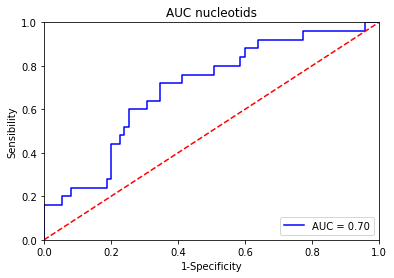

In [49]:
#nucléotides train
roc_curve(train_predictions, ytrain, 0)

In [ ]:
#hème train
roc_curve(train_predictions, ytrain, 1)

In [ ]:
#nucléotide test
roc_curve(test_predictions, ytest, 0)

In [ ]:
#hèmes test
roc_curve(test_predictions, ytest, 1)

Train heme:

In [ ]:
tp, fp, tn, fn, acc, ppv, tnr, tpr, fpr, mcc = metrics(train_predictions, ytrain[:1])
print("TP:{:.2f}%".format(tp))
print("FP:{:.2f}%".format(fp))
print("TN:{:.2f}".format(tn))
print("FN:{:.2f}".format(fn))
print("ACC = {:.2f}%".format(acc))
print("PPV = {:.2f}%".format(ppv))
print("TNR = {:.2f}%".format(tnr))
print("TPR = {:.2f}%".format(tpr))
print("FPR = {:.2f}%".format(fpr))
print("MCC = {:.2f}".format(mcc))

Train nucleotides:

In [ ]:
tp, fp, tn, fn, acc, ppv, tnr, tpr, fpr, mcc = metrics(train_predictions, ytrain[:0])
print("TP:{:.2f}%".format(tp))
print("FP:{:.2f}%".format(fp))
print("TN:{:.2f}".format(tn))
print("FN:{:.2f}".format(fn))
print("ACC = {:.2f}%".format(acc))
print("PPV = {:.2f}%".format(ppv))
print("TNR = {:.2f}%".format(tnr))
print("TPR = {:.2f}%".format(tpr))
print("FPR = {:.2f}%".format(fpr))
print("MCC = {:.2f}".format(mcc))

Test heme:

In [ ]:
tp, fp, tn, fn, acc, ppv, tnr, tpr, fpr, mcc = metrics(test_predictions, ytest[:1])
print("TP:{:.2f}%".format(tp))
print("FP:{:.2f}%".format(fp))
print("TN:{:.2f}".format(tn))
print("FN:{:.2f}".format(fn))
print("ACC = {:.2f}%".format(acc))
print("PPV = {:.2f}%".format(ppv))
print("TNR = {:.2f}%".format(tnr))
print("TPR = {:.2f}%".format(tpr))
print("FPR = {:.2f}%".format(fpr))
print("MCC = {:.2f}".format(mcc))

Test nucléotides:

In [ ]:
tp, fp, tn, fn, acc, ppv, tnr, tpr, fpr, mcc = metrics(test_predictions, ytest[:0])
print("TP:{:.2f}%".format(tp))
print("FP:{:.2f}%".format(fp))
print("TN:{:.2f}".format(tn))
print("FN:{:.2f}".format(fn))
print("ACC = {:.2f}%".format(acc))
print("PPV = {:.2f}%".format(ppv))
print("TNR = {:.2f}%".format(tnr))
print("TPR = {:.2f}%".format(tpr))
print("FPR = {:.2f}%".format(fpr))
print("MCC = {:.2f}".format(mcc))